Get Packages

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Get Data Set. Make the Required Transformation

In [3]:
train_transforms = transforms.Compose([
                                        transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                        transforms.Resize((28, 28)),
                                        #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [7]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Data Loading

In [4]:
def dataloading(IsGBN):
  train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
  test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  SEED = 1
# CUDA?
  use_cuda = torch.cuda.is_available()
  print("CUDA Available?", use_cuda)


  torch.manual_seed(SEED)

  if use_cuda:
    torch.cuda.manual_seed(SEED)

  # dataloader arguments - something you'll fetch these from cmdprmt
  if IsGBN == 'GBN':
    dataloader_args = dict(shuffle=True, batch_size= 128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=128)
  else:
    dataloader_args = dict(shuffle=True, batch_size= 32, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size= 32)

  # train dataloader
  train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

  return train_loader,test_loader

 


In [5]:
check_train, check_test = dataloading('BN')
dataiter = iter(check_train)
images, labels = dataiter.next()
print((images.shape))
print(len(check_train))

CUDA Available? False
torch.Size([32, 1, 28, 28])
1875


Set-up **Model**

In [6]:
dropout_value = 0.0
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(10), nn.Dropout(dropout_value)) 
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(16), nn.Dropout(dropout_value))
        self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), bias=False))
        self.pool1 = nn.MaxPool2d(2,2)
        
        
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels= 10, out_channels= 16, kernel_size=(3, 3), padding=1, bias=False), nn.ReLU(),nn.BatchNorm2d(16), nn.Dropout(dropout_value))
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels= 20, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(20), nn.Dropout(dropout_value))
        self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), bias=False))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels= 16, kernel_size=(3, 3), bias=False),nn.ReLU(),nn.BatchNorm2d(16), nn.Dropout(dropout_value))
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=5))
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), bias=False))
        
         

    def forward(self, x):
        x = self.convblock1(x) 
        x = self.convblock2(x) 
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x) 
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
modelBN = Net().to(device)
#modelGBN = Net().to(devide)
summary(modelBN, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,440
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             160
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,440
             ReLU-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
          Dropout-14           [-1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [7]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias


class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [8]:
dropout_value = 0.0
class NetGBN(nn.Module):
    def __init__(self):
        super(NetGBN, self).__init__()
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),GhostBatchNorm(10,2), nn.Dropout(dropout_value)) 
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),GhostBatchNorm(16,2), nn.Dropout(dropout_value))
        self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), bias=False))
        self.pool1 = nn.MaxPool2d(2,2)
        
        
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels= 10, out_channels= 16, kernel_size=(3, 3), padding=1, bias=False), nn.ReLU(),GhostBatchNorm(16,2), nn.Dropout(dropout_value))
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels= 20, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),GhostBatchNorm(20,2), nn.Dropout(dropout_value))
        self.convblock6 = nn.Sequential(nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), bias=False))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=10, out_channels= 16, kernel_size=(3, 3), bias=False),nn.ReLU(),GhostBatchNorm(16,2), nn.Dropout(dropout_value))
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=5))
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), bias=False))
        
         

    def forward(self, x):
        x = self.convblock1(x) 
        x = self.convblock2(x) 
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x) 
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)
  
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
modelGBN = NetGBN().to(device)
#modelGBN = Net().to(devide)
summary(modelGBN, input_size=(1, 28, 28))


cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
    GhostBatchNorm-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,440
              ReLU-6           [-1, 16, 28, 28]               0
    GhostBatchNorm-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             160
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,440
             ReLU-12           [-1, 16, 14, 14]               0
   GhostBatchNorm-13           [-1, 16, 14, 14]              32
          Dropout-14           [-1,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Set-up Train and Test Model

In [9]:
from tqdm import tqdm





misclassified=[]
lambda1 = 0.0002
lambda2 = 0.0001

def train(model, device, train_loader, optimizer, epoch, reg):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get full data of one batch
    data, target = data.to(device), target.to(device)

    # Initgrad
    optimizer.zero_grad()
    y_pred = model(data)

    # Calculate loss for that batch
    loss = F.nll_loss(y_pred, target)
   
    regularization_loss1 = 0
    regularization_loss2 = 0

    #Update loss based on regularization
    if reg=="None":
      loss = loss
      train_loss += loss.item()
    elif reg=="L1":
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
      loss += (lambda1*regularization_loss1)
      train_loss += loss.item()
      
    elif reg=="L2":
      for param in model.parameters():
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda2*regularization_loss2)
      train_loss += loss.item()
      
    else:
      for param in model.parameters():
        regularization_loss1 += torch.norm(param,1)
        regularization_loss2 += torch.norm(param,2)
      loss += (lambda1*regularization_loss1+lambda2*regularization_loss2)
      train_loss += loss.item()
      
    # Backpropagation an optimization for that batch
    loss.backward()
    optimizer.step()


    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_loss /= len(train_loader.dataset)
  train_losses.append(train_loss)
  train_acc.append(100*correct/processed)
    



def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            if epoch == 13 :
              temp = pred.eq(target.view_as(pred)).sum().item()
              temp1 = target.view_as(pred)
              if(len(misclassified)<25):
                #print('Check missclass')
                for i in range(len(temp1)):
                  if(temp1[i]!=pred[i]):
                    misclassified.append([data[i],temp1[i],pred[i]])
                  if(len(misclassified)==25):
                    break

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test_Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append((100. * correct / len(test_loader.dataset)))




Run Model

In [10]:
from torch.optim.lr_scheduler import StepLR
import copy
torch.manual_seed(2)

model_type = {}
validation_acc = {}
validation_loss = {}
train_lossmat = {}
train_accmat = {}
missclass = {}




  
# Adding list as value 
model_type["BNL1"] = ['BN', 'L1']
model_type["BNL2"] = ['BN', 'L2']
model_type["BNL1L2"] = ['BN', 'All']
model_type["GBN"] = ['GBN', 'NRL']
model_type["GBNL1L2"] = ['GBN', 'ALL']

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


for key, value in model_type.items():
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []
  misclassified=[]
  
  
  
  if value[0] == 'BN':
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
    train_loader, test_loader = dataloading('BN')
  else:
    model = NetGBN().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.1)
    train_loader, test_loader = dataloading('GBN')
    
  EPOCHS = 15
  
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, value[1])
    test(model, device, test_loader, epoch)
    scheduler.step()
  validation_acc[key] = copy.deepcopy(test_acc)
  validation_loss[key] = copy.deepcopy(test_losses)

  train_lossmat[key] = copy.deepcopy(train_losses)
  train_accmat[key] = copy.deepcopy(train_accmat)
  missclass[key] = copy.deepcopy(misclassified)





  0%|          | 0/1875 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=2.4120123386383057 Batch_id=1 Accuracy=6.25:   0%|          | 2/1875 [00:00<02:32, 12.30it/s]

CUDA Available? False
EPOCH: 0


Loss=0.14542751014232635 Batch_id=1874 Accuracy=91.72: 100%|██████████| 1875/1875 [02:02<00:00, 15.34it/s]
Loss=0.21435624361038208 Batch_id=2 Accuracy=96.88:   0%|          | 2/1875 [00:00<01:59, 15.70it/s]


Test set: Average loss: 0.0796, Test_Accuracy: 9777/10000 (97.77%)

EPOCH: 1


Loss=0.17323273420333862 Batch_id=1874 Accuracy=97.11: 100%|██████████| 1875/1875 [02:02<00:00, 15.30it/s]
Loss=0.2392313927412033 Batch_id=2 Accuracy=93.75:   0%|          | 2/1875 [00:00<02:01, 15.48it/s]


Test set: Average loss: 0.0600, Test_Accuracy: 9805/10000 (98.05%)

EPOCH: 2


Loss=0.18637891113758087 Batch_id=1874 Accuracy=97.60: 100%|██████████| 1875/1875 [02:02<00:00, 15.27it/s]
Loss=0.14916545152664185 Batch_id=2 Accuracy=96.88:   0%|          | 2/1875 [00:00<02:02, 15.25it/s]


Test set: Average loss: 0.0923, Test_Accuracy: 9717/10000 (97.17%)

EPOCH: 3


Loss=0.26017966866493225 Batch_id=1874 Accuracy=97.83: 100%|██████████| 1875/1875 [02:01<00:00, 15.41it/s]
Loss=0.14314453303813934 Batch_id=2 Accuracy=100.00:   0%|          | 2/1875 [00:00<01:59, 15.70it/s]


Test set: Average loss: 0.0518, Test_Accuracy: 9835/10000 (98.35%)

EPOCH: 4


Loss=0.16093279421329498 Batch_id=1874 Accuracy=98.58: 100%|██████████| 1875/1875 [02:01<00:00, 15.45it/s]
Loss=0.1321629136800766 Batch_id=2 Accuracy=96.88:   0%|          | 2/1875 [00:00<02:01, 15.41it/s]


Test set: Average loss: 0.0261, Test_Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.1274188607931137 Batch_id=1874 Accuracy=98.76: 100%|██████████| 1875/1875 [02:01<00:00, 15.47it/s]
Loss=0.1192980632185936 Batch_id=1 Accuracy=100.00:   0%|          | 2/1875 [00:00<02:31, 12.40it/s]


Test set: Average loss: 0.0239, Test_Accuracy: 9927/10000 (99.27%)

EPOCH: 6


Loss=0.1761643886566162 Batch_id=1874 Accuracy=98.76: 100%|██████████| 1875/1875 [02:04<00:00, 15.08it/s]
Loss=0.15752069652080536 Batch_id=2 Accuracy=97.92:   0%|          | 2/1875 [00:00<01:56, 16.10it/s]


Test set: Average loss: 0.0240, Test_Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.12860536575317383 Batch_id=1874 Accuracy=98.84: 100%|██████████| 1875/1875 [02:06<00:00, 14.81it/s]
Loss=0.12455582618713379 Batch_id=2 Accuracy=97.92:   0%|          | 2/1875 [00:00<02:01, 15.37it/s]


Test set: Average loss: 0.0243, Test_Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.11062087118625641 Batch_id=1874 Accuracy=98.93: 100%|██████████| 1875/1875 [02:01<00:00, 15.45it/s]
Loss=0.11757819354534149 Batch_id=2 Accuracy=100.00:   0%|          | 2/1875 [00:00<01:55, 16.26it/s]


Test set: Average loss: 0.0231, Test_Accuracy: 9930/10000 (99.30%)

EPOCH: 9


Loss=0.11286503821611404 Batch_id=1874 Accuracy=98.94: 100%|██████████| 1875/1875 [02:00<00:00, 15.58it/s]
Loss=0.12979727983474731 Batch_id=2 Accuracy=97.92:   0%|          | 2/1875 [00:00<01:56, 16.13it/s]


Test set: Average loss: 0.0231, Test_Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.1315598487854004 Batch_id=1874 Accuracy=98.93: 100%|██████████| 1875/1875 [01:59<00:00, 15.66it/s]
Loss=0.12336157262325287 Batch_id=2 Accuracy=96.88:   0%|          | 2/1875 [00:00<01:55, 16.21it/s]


Test set: Average loss: 0.0224, Test_Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.18556362390518188 Batch_id=1874 Accuracy=98.99: 100%|██████████| 1875/1875 [01:59<00:00, 15.72it/s]
Loss=0.15313810110092163 Batch_id=2 Accuracy=98.96:   0%|          | 2/1875 [00:00<01:57, 15.99it/s]


Test set: Average loss: 0.0223, Test_Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.11292655020952225 Batch_id=1874 Accuracy=98.96: 100%|██████████| 1875/1875 [02:00<00:00, 15.57it/s]
Loss=0.13830707967281342 Batch_id=2 Accuracy=100.00:   0%|          | 2/1875 [00:00<01:55, 16.21it/s]


Test set: Average loss: 0.0224, Test_Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.1171656996011734 Batch_id=1874 Accuracy=98.96: 100%|██████████| 1875/1875 [02:00<00:00, 15.60it/s]
Loss=0.1271468698978424 Batch_id=2 Accuracy=100.00:   0%|          | 2/1875 [00:00<01:59, 15.65it/s] 


Test set: Average loss: 0.0227, Test_Accuracy: 9928/10000 (99.28%)

EPOCH: 14


Loss=0.11070629209280014 Batch_id=1874 Accuracy=99.02: 100%|██████████| 1875/1875 [02:01<00:00, 15.39it/s]
Loss=2.297795534133911 Batch_id=1 Accuracy=9.38:   0%|          | 2/1875 [00:00<02:06, 14.83it/s]


Test set: Average loss: 0.0219, Test_Accuracy: 9934/10000 (99.34%)

CUDA Available? False
EPOCH: 0


Loss=0.03222430497407913 Batch_id=1874 Accuracy=92.45: 100%|██████████| 1875/1875 [02:04<00:00, 15.03it/s]
Loss=0.14714325964450836 Batch_id=2 Accuracy=97.92:   0%|          | 2/1875 [00:00<02:00, 15.54it/s]


Test set: Average loss: 0.0657, Test_Accuracy: 9798/10000 (97.98%)

EPOCH: 1


Loss=0.04130563884973526 Batch_id=1874 Accuracy=97.41: 100%|██████████| 1875/1875 [02:03<00:00, 15.12it/s]
Loss=0.07378248125314713 Batch_id=2 Accuracy=95.83:   0%|          | 2/1875 [00:00<02:01, 15.40it/s] 


Test set: Average loss: 0.0476, Test_Accuracy: 9839/10000 (98.39%)

EPOCH: 2


Loss=0.2124628871679306 Batch_id=1874 Accuracy=97.95: 100%|██████████| 1875/1875 [02:02<00:00, 15.25it/s]
Loss=0.07009218633174896 Batch_id=2 Accuracy=100.00:   0%|          | 2/1875 [00:00<01:56, 16.10it/s]


Test set: Average loss: 0.0345, Test_Accuracy: 9889/10000 (98.89%)

EPOCH: 3


Loss=0.1961030662059784 Batch_id=1874 Accuracy=98.14: 100%|██████████| 1875/1875 [02:02<00:00, 15.27it/s]
Loss=0.01092347502708435 Batch_id=2 Accuracy=100.00:   0%|          | 2/1875 [00:00<01:58, 15.76it/s] 


Test set: Average loss: 0.0368, Test_Accuracy: 9883/10000 (98.83%)

EPOCH: 4


Loss=0.020006751641631126 Batch_id=1874 Accuracy=98.65: 100%|██████████| 1875/1875 [02:03<00:00, 15.19it/s]
Loss=0.03017740324139595 Batch_id=2 Accuracy=97.92:   0%|          | 2/1875 [00:00<01:56, 16.07it/s]


Test set: Average loss: 0.0245, Test_Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.010953918099403381 Batch_id=1874 Accuracy=98.83: 100%|██████████| 1875/1875 [02:02<00:00, 15.26it/s]
Loss=0.11617279052734375 Batch_id=2 Accuracy=97.92:   0%|          | 2/1875 [00:00<01:57, 15.87it/s]  


Test set: Average loss: 0.0228, Test_Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.042823903262615204 Batch_id=1874 Accuracy=98.83: 100%|██████████| 1875/1875 [02:02<00:00, 15.27it/s]
Loss=0.0553361140191555 Batch_id=2 Accuracy=97.92:   0%|          | 2/1875 [00:00<02:02, 15.27it/s]


Test set: Average loss: 0.0225, Test_Accuracy: 9925/10000 (99.25%)

EPOCH: 7


Loss=0.013011043891310692 Batch_id=1874 Accuracy=98.89: 100%|██████████| 1875/1875 [02:02<00:00, 15.32it/s]
Loss=0.07425286620855331 Batch_id=2 Accuracy=96.88:   0%|          | 2/1875 [00:00<01:59, 15.66it/s] 


Test set: Average loss: 0.0213, Test_Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.0121665233746171 Batch_id=1874 Accuracy=98.96: 100%|██████████| 1875/1875 [02:03<00:00, 15.22it/s]
Loss=0.011184867471456528 Batch_id=2 Accuracy=100.00:   0%|          | 2/1875 [00:00<02:03, 15.20it/s]


Test set: Average loss: 0.0219, Test_Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.01432446762919426 Batch_id=1874 Accuracy=98.95: 100%|██████████| 1875/1875 [02:05<00:00, 14.90it/s]
Loss=0.02026546746492386 Batch_id=2 Accuracy=98.96:   0%|          | 2/1875 [00:00<01:59, 15.69it/s]


Test set: Average loss: 0.0210, Test_Accuracy: 9930/10000 (99.30%)

EPOCH: 10


Loss=0.022394798696041107 Batch_id=1874 Accuracy=98.93: 100%|██████████| 1875/1875 [02:04<00:00, 15.03it/s]
Loss=0.04152002930641174 Batch_id=2 Accuracy=98.96:   0%|          | 2/1875 [00:00<01:56, 16.12it/s]


Test set: Average loss: 0.0213, Test_Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.07551677525043488 Batch_id=1874 Accuracy=99.00: 100%|██████████| 1875/1875 [02:05<00:00, 14.96it/s]
Loss=0.026943907141685486 Batch_id=2 Accuracy=100.00:   0%|          | 2/1875 [00:00<02:02, 15.29it/s]


Test set: Average loss: 0.0217, Test_Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.0738435760140419 Batch_id=1874 Accuracy=98.95: 100%|██████████| 1875/1875 [02:04<00:00, 15.09it/s]
Loss=0.029896613210439682 Batch_id=2 Accuracy=100.00:   0%|          | 2/1875 [00:00<01:56, 16.02it/s]


Test set: Average loss: 0.0216, Test_Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.01570768654346466 Batch_id=1874 Accuracy=98.96: 100%|██████████| 1875/1875 [02:04<00:00, 15.09it/s]
Loss=0.052673906087875366 Batch_id=2 Accuracy=98.96:   0%|          | 2/1875 [00:00<01:57, 15.94it/s]


Test set: Average loss: 0.0217, Test_Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.020423749461770058 Batch_id=1874 Accuracy=99.01: 100%|██████████| 1875/1875 [02:03<00:00, 15.12it/s]
Loss=2.3980374336242676 Batch_id=1 Accuracy=9.38:   0%|          | 2/1875 [00:00<01:57, 15.98it/s]


Test set: Average loss: 0.0209, Test_Accuracy: 9926/10000 (99.26%)

CUDA Available? False
EPOCH: 0


Loss=0.17537936568260193 Batch_id=1874 Accuracy=92.13: 100%|██████████| 1875/1875 [02:02<00:00, 15.25it/s]
Loss=0.1775200068950653 Batch_id=1 Accuracy=100.00:   0%|          | 2/1875 [00:00<02:00, 15.57it/s]


Test set: Average loss: 0.0745, Test_Accuracy: 9765/10000 (97.65%)

EPOCH: 1


Loss=0.19537243247032166 Batch_id=1874 Accuracy=97.06: 100%|██████████| 1875/1875 [02:01<00:00, 15.41it/s]
Loss=0.240319162607193 Batch_id=2 Accuracy=95.83:   0%|          | 2/1875 [00:00<01:52, 16.59it/s]  


Test set: Average loss: 0.0659, Test_Accuracy: 9781/10000 (97.81%)

EPOCH: 2


Loss=0.3459610939025879 Batch_id=1874 Accuracy=97.52: 100%|██████████| 1875/1875 [02:01<00:00, 15.43it/s]
Loss=0.17970404028892517 Batch_id=1 Accuracy=98.44:   0%|          | 2/1875 [00:00<02:02, 15.27it/s]


Test set: Average loss: 0.0476, Test_Accuracy: 9851/10000 (98.51%)

EPOCH: 3


Loss=0.3233591914176941 Batch_id=1874 Accuracy=97.69: 100%|██████████| 1875/1875 [02:02<00:00, 15.35it/s]
Loss=0.13323727250099182 Batch_id=2 Accuracy=98.96:   0%|          | 2/1875 [00:00<01:58, 15.81it/s]


Test set: Average loss: 0.0445, Test_Accuracy: 9860/10000 (98.60%)

EPOCH: 4


Loss=0.15788470208644867 Batch_id=1874 Accuracy=98.53: 100%|██████████| 1875/1875 [02:01<00:00, 15.37it/s]
Loss=0.20267750322818756 Batch_id=2 Accuracy=96.88:   0%|          | 2/1875 [00:00<01:55, 16.16it/s]


Test set: Average loss: 0.0236, Test_Accuracy: 9921/10000 (99.21%)

EPOCH: 5


Loss=0.13320410251617432 Batch_id=1874 Accuracy=98.69: 100%|██████████| 1875/1875 [02:01<00:00, 15.40it/s]
Loss=0.23496060073375702 Batch_id=2 Accuracy=97.92:   0%|          | 2/1875 [00:00<02:03, 15.22it/s] 


Test set: Average loss: 0.0225, Test_Accuracy: 9929/10000 (99.29%)

EPOCH: 6


Loss=0.14955665171146393 Batch_id=1874 Accuracy=98.73: 100%|██████████| 1875/1875 [02:02<00:00, 15.34it/s]
Loss=0.15829172730445862 Batch_id=2 Accuracy=97.92:   0%|          | 2/1875 [00:00<02:00, 15.52it/s]


Test set: Average loss: 0.0229, Test_Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.12290224432945251 Batch_id=1874 Accuracy=98.77: 100%|██████████| 1875/1875 [02:02<00:00, 15.33it/s]
Loss=0.1575467735528946 Batch_id=2 Accuracy=97.92:   0%|          | 2/1875 [00:00<01:57, 15.95it/s]


Test set: Average loss: 0.0214, Test_Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.11565442383289337 Batch_id=1874 Accuracy=98.87: 100%|██████████| 1875/1875 [02:02<00:00, 15.37it/s]
Loss=0.11779643595218658 Batch_id=2 Accuracy=100.00:   0%|          | 2/1875 [00:00<02:00, 15.50it/s]


Test set: Average loss: 0.0212, Test_Accuracy: 9926/10000 (99.26%)

EPOCH: 9


Loss=0.14267084002494812 Batch_id=1874 Accuracy=98.88: 100%|██████████| 1875/1875 [02:02<00:00, 15.33it/s]
Loss=0.12206648290157318 Batch_id=2 Accuracy=98.96:   0%|          | 2/1875 [00:00<01:58, 15.81it/s]


Test set: Average loss: 0.0206, Test_Accuracy: 9936/10000 (99.36%)

EPOCH: 10


Loss=0.12564130127429962 Batch_id=1874 Accuracy=98.83: 100%|██████████| 1875/1875 [02:03<00:00, 15.18it/s]
Loss=0.2553408145904541 Batch_id=1 Accuracy=93.75:   0%|          | 2/1875 [00:00<02:10, 14.39it/s]


Test set: Average loss: 0.0208, Test_Accuracy: 9931/10000 (99.31%)

EPOCH: 11


Loss=0.15490888059139252 Batch_id=1874 Accuracy=98.93: 100%|██████████| 1875/1875 [02:04<00:00, 15.07it/s]
Loss=0.1306275725364685 Batch_id=2 Accuracy=98.96:   0%|          | 2/1875 [00:00<02:00, 15.56it/s] 


Test set: Average loss: 0.0207, Test_Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.13827826082706451 Batch_id=1874 Accuracy=98.97: 100%|██████████| 1875/1875 [02:04<00:00, 15.07it/s]
Loss=0.12859179079532623 Batch_id=2 Accuracy=100.00:   0%|          | 2/1875 [00:00<01:56, 16.09it/s]


Test set: Average loss: 0.0209, Test_Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.11644163727760315 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [02:03<00:00, 15.17it/s]
Loss=0.11572768539190292 Batch_id=2 Accuracy=100.00:   0%|          | 2/1875 [00:00<01:57, 16.00it/s]


Test set: Average loss: 0.0211, Test_Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.132769376039505 Batch_id=1874 Accuracy=98.86: 100%|██████████| 1875/1875 [02:03<00:00, 15.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Test_Accuracy: 9936/10000 (99.36%)

CUDA Available? False
EPOCH: 0


Loss=0.24423354864120483 Batch_id=468 Accuracy=84.11: 100%|██████████| 469/469 [01:38<00:00,  4.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2441, Test_Accuracy: 9298/10000 (92.98%)

EPOCH: 1


Loss=0.241725355386734 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [01:38<00:00,  4.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0894, Test_Accuracy: 9762/10000 (97.62%)

EPOCH: 2


Loss=0.2079123854637146 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [01:37<00:00,  4.79it/s]
Loss=0.15461774170398712 Batch_id=0 Accuracy=99.22:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0713, Test_Accuracy: 9779/10000 (97.79%)

EPOCH: 3


Loss=0.21012161672115326 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [01:38<00:00,  4.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Test_Accuracy: 9831/10000 (98.31%)

EPOCH: 4


Loss=0.20768508315086365 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [01:38<00:00,  4.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Test_Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.128432959318161 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [01:39<00:00,  4.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Test_Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.15627513825893402 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [01:38<00:00,  4.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Test_Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.13173024356365204 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [01:37<00:00,  4.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Test_Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.14781679213047028 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [01:40<00:00,  4.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Test_Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.13680505752563477 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [01:38<00:00,  4.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Test_Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.11565671861171722 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [01:38<00:00,  4.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Test_Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.12451893091201782 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [01:38<00:00,  4.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Test_Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.14729395508766174 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [01:39<00:00,  4.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Test_Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.12398434430360794 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [01:37<00:00,  4.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Test_Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.16607818007469177 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [01:37<00:00,  4.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Test_Accuracy: 9920/10000 (99.20%)

CUDA Available? False
EPOCH: 0


Loss=0.24423354864120483 Batch_id=468 Accuracy=84.11: 100%|██████████| 469/469 [01:36<00:00,  4.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2441, Test_Accuracy: 9298/10000 (92.98%)

EPOCH: 1


Loss=0.241725355386734 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [01:36<00:00,  4.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0894, Test_Accuracy: 9762/10000 (97.62%)

EPOCH: 2


Loss=0.2079123854637146 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [01:37<00:00,  4.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0713, Test_Accuracy: 9779/10000 (97.79%)

EPOCH: 3


Loss=0.21012161672115326 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [01:36<00:00,  4.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Test_Accuracy: 9831/10000 (98.31%)

EPOCH: 4


Loss=0.20768508315086365 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [01:36<00:00,  4.86it/s]
Loss=0.1965891271829605 Batch_id=0 Accuracy=96.88:   0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Test_Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.128432959318161 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [01:36<00:00,  4.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Test_Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.15627513825893402 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [01:37<00:00,  4.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Test_Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.13173024356365204 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [01:39<00:00,  4.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Test_Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.14781679213047028 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [01:40<00:00,  4.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Test_Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.13680505752563477 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [01:38<00:00,  4.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Test_Accuracy: 9918/10000 (99.18%)

EPOCH: 10


Loss=0.11565671861171722 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [01:39<00:00,  4.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Test_Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.12451893091201782 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [01:39<00:00,  4.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Test_Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.14729395508766174 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [01:38<00:00,  4.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Test_Accuracy: 9922/10000 (99.22%)

EPOCH: 13


Loss=0.12398434430360794 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [01:38<00:00,  4.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Test_Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.16607818007469177 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [01:37<00:00,  4.80it/s]



Test set: Average loss: 0.0275, Test_Accuracy: 9920/10000 (99.20%)



In [16]:
print(validation_acc['GBN'], validation_acc['GBNL1L2'])


[92.98, 97.62, 97.79, 98.31, 99.04, 99.18, 99.16, 99.27, 99.21, 99.18, 99.21, 99.17, 99.22, 99.22, 99.2] [92.98, 97.62, 97.79, 98.31, 99.04, 99.18, 99.16, 99.27, 99.21, 99.18, 99.21, 99.17, 99.22, 99.22, 99.2]


In [10]:
def plot_graphs(df_array, legend_arr, xlabel="Epochs", ylabel="Accuracy"):
    fig, ax = plt.subplots(figsize=(15, 6))
    for i in range(len(df_array)):
        ax.plot(range(2),
            df_array[i])
    ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.legend(legend_arr)
    plt.show()

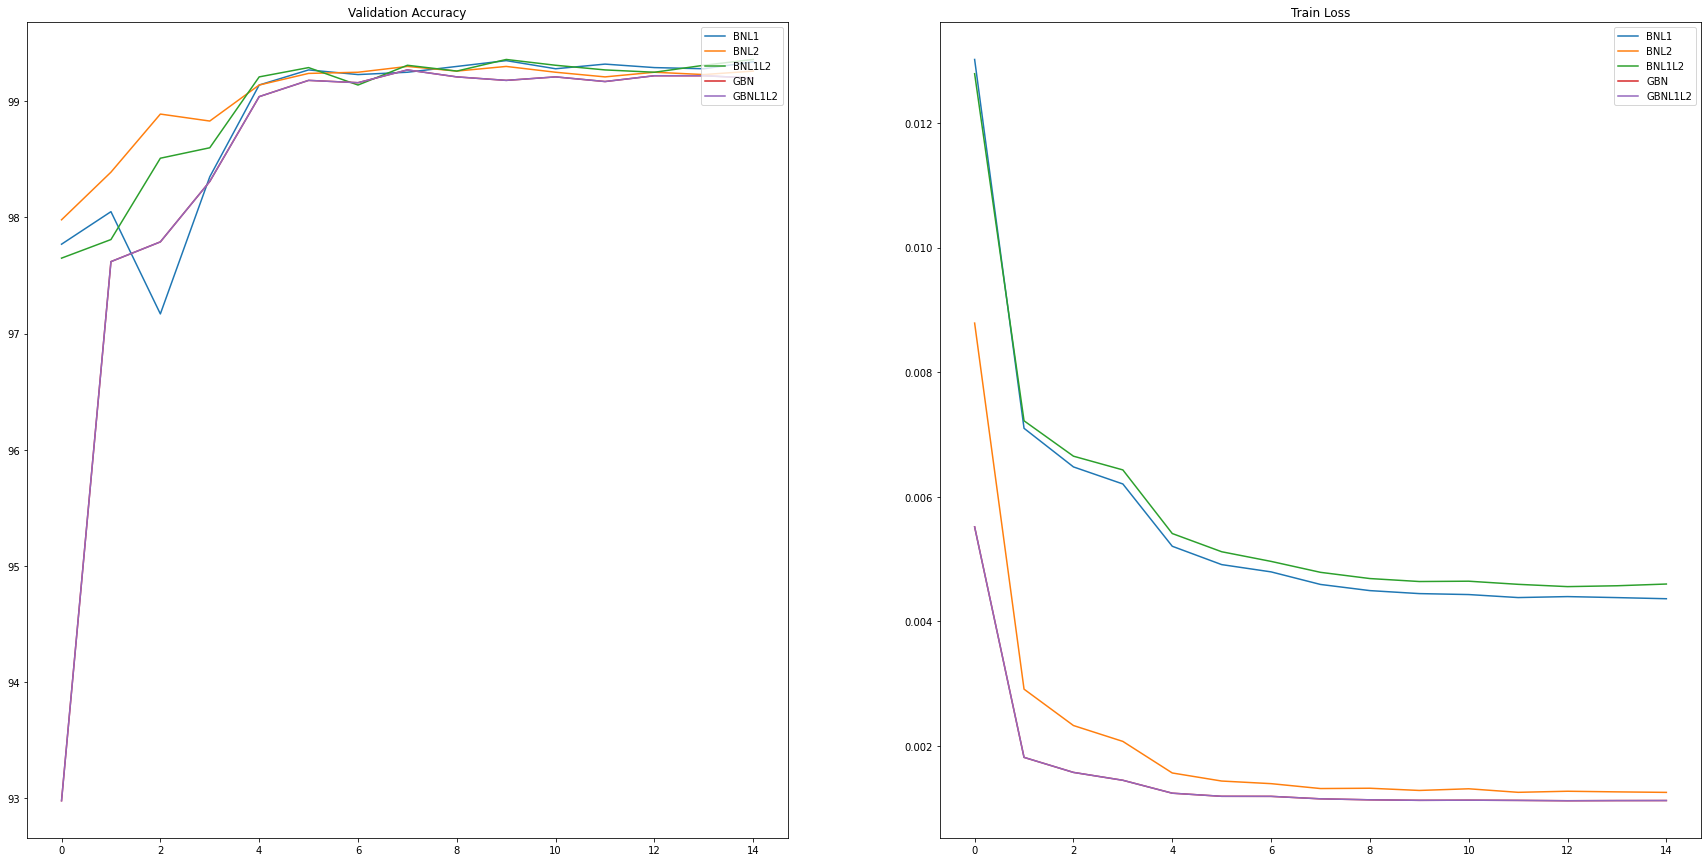

In [32]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2,figsize=(30,15))
#axs[0].set_ylim(92, 100)
axs[0].set_title('Validation Accuracy')
axs[1].set_title('Train Loss')

axs[0].plot(validation_acc['BNL1'])
axs[0].plot(validation_acc['BNL2'])
axs[0].plot(validation_acc['BNL1L2'])
axs[0].plot(validation_acc['GBN'])
axs[0].plot(validation_acc['GBNL1L2'])
axs[1].plot(train_lossmat['BNL1'])
axs[1].plot(train_lossmat['BNL2'])
axs[1].plot(train_lossmat['BNL1L2'])
axs[1].plot(train_lossmat['GBN'])
axs[1].plot(train_lossmat['GBNL1L2'])
axs[0].legend(['BNL1', 'BNL2', 'BNL1L2', 'GBN', 'GBNL1L2'], loc='upper right')
axs[1].legend(['BNL1', 'BNL2', 'BNL1L2', 'GBN', 'GBNL1L2'], loc='upper right')

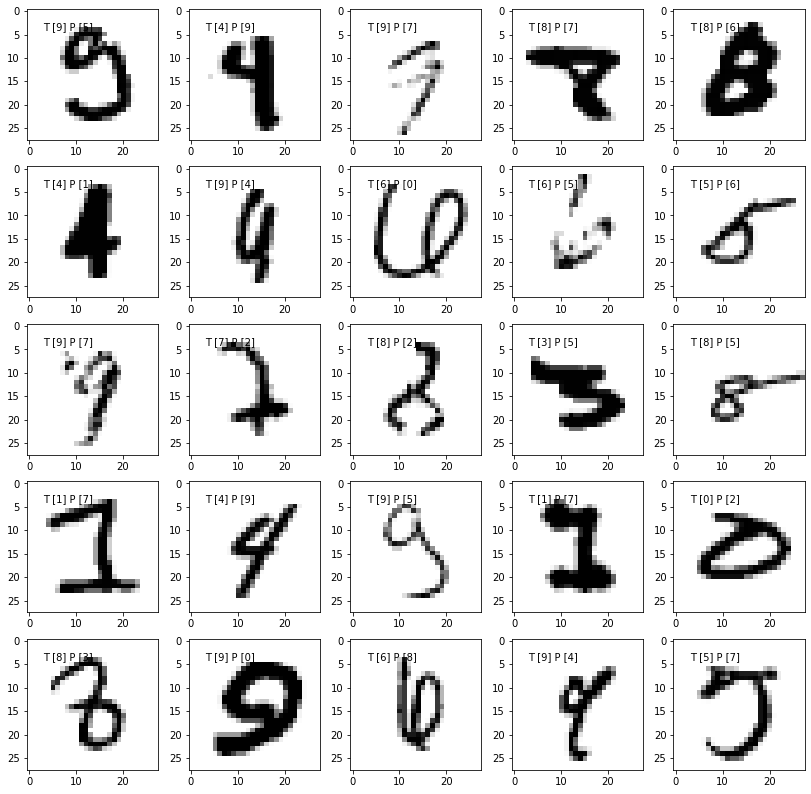

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5,5,figsize=(14,14))
index=0
for i in range(5):
  for j in range(5):
    data,t,p = missclass['GBN'][index]
    axs[i,j].imshow(data.cpu().numpy().squeeze(), cmap='gray_r')
    #axs[i,j].set_title(str(t.cpu().numpy())+" "+str(p.cpu().numpy()))
    axs[i,j].annotate("T "+str(t.cpu().numpy())+" P "+str(p.cpu().numpy()),(3,4))
    index+=1;